In [1]:
# vscode won't find the correct cwd when the jupyter server runs remotely (in docker)
import os
try:
    os.chdir('/catkin_ws/src/notebooks/') # notebook bath in docker
except:
    pass

In [3]:
# import modules
import pandas as pd
import numpy as np
from scipy.integrate import cumtrapz
from numpy import sin,cos,pi
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [20, 10]


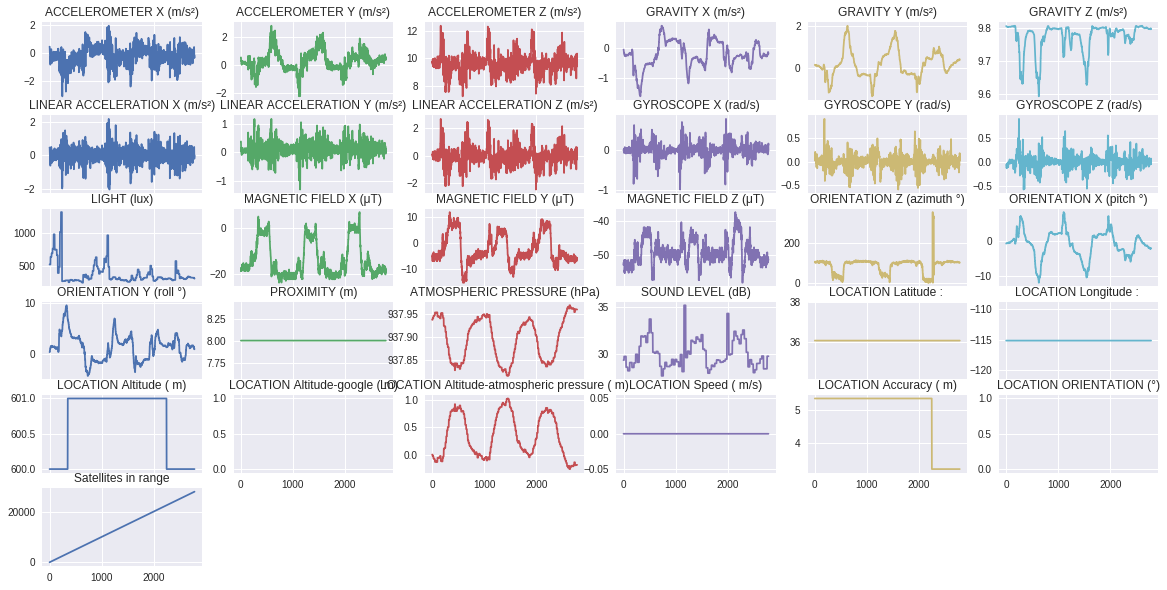

In [6]:

# import data from CSV
df = pd.read_csv('imu_data/3 1m lifts.csv')
# Take a look at all sensor outputs
df.plot(subplots=True,sharex=True,layout=(6,6),title=list(df.columns[:-3]),
        legend=False)
dt = 0.01 # Sampling at 100Hz
# Convert orientation units to radians
cols_angles = ['ORIENTATION X (pitch °)','ORIENTATION Y (roll °)',
               'ORIENTATION Z (azimuth °)']
for axis in cols_angles:
    df[axis] = df[axis] * pi/180

# Transform body frame accelerations into the inertial (Earth) frame
    # Rotation matrices
def R_x(x):
    # body frame rotation about x axis
    return np.array([[1,      0,       0],
                     [0,cos(-x),-sin(-x)],
                     [0,sin(-x), cos(-x)]])

def R_y(y):
    # body frame rotation about y axis
    return np.array([[cos(-y),0,-sin(-y)],
                    [0,      1,        0],
                    [sin(-y), 0, cos(-y)]])

def R_z(z):
    # body frame rotation about z axis
    return np.array([[cos(-z),-sin(-z),0],
                     [sin(-z), cos(-z),0],
                     [0,      0,       1]])

# Set up arrays to hold acceleration data for transfromation
accel = np.array([df['ACCELEROMETER X (m/s²)'],
                  df['ACCELEROMETER Y (m/s²)'],
                  df['ACCELEROMETER Z (m/s²)']])
grav = np.array([df['GRAVITY X (m/s²)'],
                 df['GRAVITY Y (m/s²)'],
                 df['GRAVITY Z (m/s²)']])
line = np.array([df['LINEAR ACCELERATION X (m/s²)'],
                 df['LINEAR ACCELERATION Y (m/s²)'],
                 df['LINEAR ACCELERATION Z (m/s²)']])

# Set up arrays to hold euler angles for rotation matrices
pitch = df['ORIENTATION X (pitch °)']
roll = df['ORIENTATION Y (roll °)']
yaw = df['ORIENTATION Z (azimuth °)']

# Initilize arrays for new transformed accelerations
earth_accels = np.empty(accel.shape)
earth_gravity = np.empty(accel.shape)
earth_linear = np.empty(accel.shape)


df.head()

In [8]:
df.keys()

Index(['ACCELEROMETER X (m/s²)', 'ACCELEROMETER Y (m/s²)',
       'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)',
       'GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
       'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',
       'GYROSCOPE X (rad/s)', 'GYROSCOPE Y (rad/s)', 'GYROSCOPE Z (rad/s)',
       'LIGHT (lux)', 'MAGNETIC FIELD X (μT)', 'MAGNETIC FIELD Y (μT)',
       'MAGNETIC FIELD Z (μT)', 'ORIENTATION Z (azimuth °)',
       'ORIENTATION X (pitch °)', 'ORIENTATION Y (roll °)', 'PROXIMITY (m)',
       'ATMOSPHERIC PRESSURE (hPa)', 'SOUND LEVEL (dB)',
       'LOCATION Latitude : ', 'LOCATION Longitude : ',
       'LOCATION Altitude ( m)', 'LOCATION Altitude-google ( m)',
       'LOCATION Altitude-atmospheric pressure ( m)', 'LOCATION Speed ( m/s)',
       'LOCATION Accuracy ( m)', 'LOCATION ORIENTATION (°)',
       'Satellites in range', 'GPS NMEA', 'Time since start in ms ',
       'YYYY-MO-DD HH-MI-SS_SSS'],
      dtype='object')

In [ ]:
from geometry_msgs.msg import PoseStamped, Point, Pose, TransformStamped, Transform
from sensor_msgs.msg import PointCloud2, PointField, Image, Imu

imu_rows = []

bag = rosbag.Bag('/bags/02.bag')
got_first_frame = False
for m in list(bag.read_messages())[:200]:
    # help(m.timestamp)
    # print(m.topic, m.timestamp)
    if m.topic.endswith("/front/image_raw"):
        DecodeImageMsg.push(m.message)
        if not got_first_frame:
            got_first_frame = True
            GroundTruth.trigger_zero_pose()
        # rospy.sleep(1.)
    elif m.topic.endswith("/pose_static"):
        t = next(t.transform for t in m.message.transforms if t.child_frame_id == "costar_husky_sensor_config_1")
        GroundTruth.push(t)
    elif m.topic.endswith("/imu/data"):
        msg: Imu = m.message
        imu_rows.append([
            msg.angular_velocity.x,
            msg.angular_velocity.y,
            msg.angular_velocity.z,
            msg.linear_acceleration.x,
            msg.linear_acceleration.y,
            msg.linear_acceleration.z,
            msg.orientation.x,
            msg.orientation.y,
            msg.orientation.z,
            msg.orientation.w,
        ])



/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/tools.py:201: UserWarning: When passing multiple axes, layout keyword is ignored
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pandas/plotting/_matplotlib/__init__.py:61: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  plot_obj.generate()


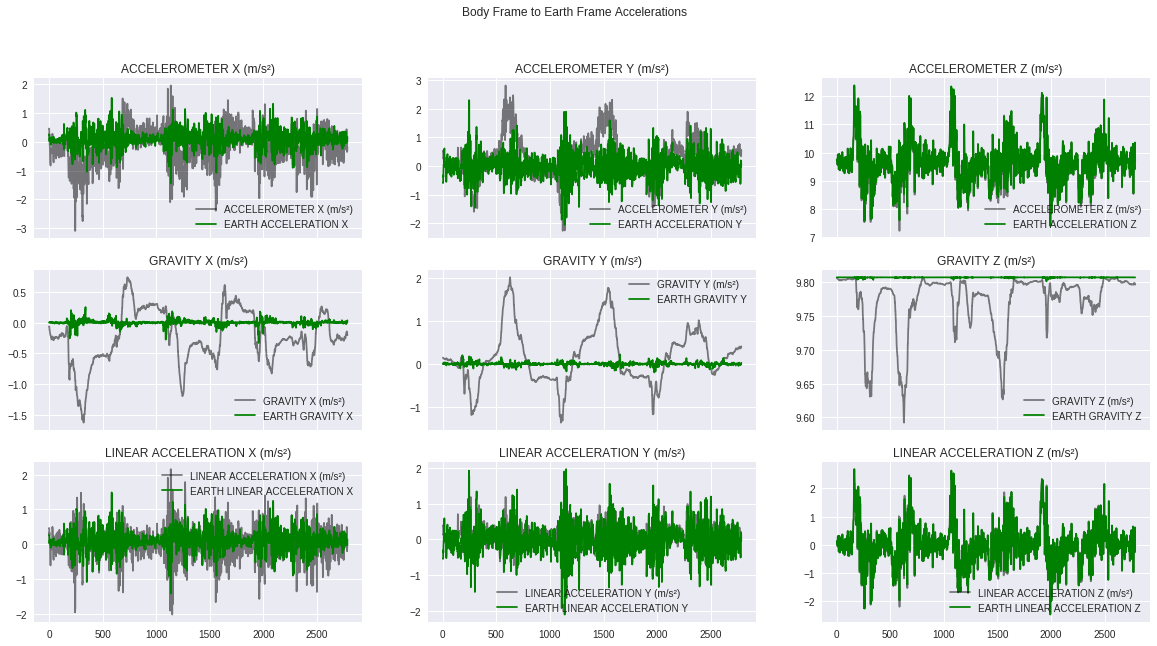

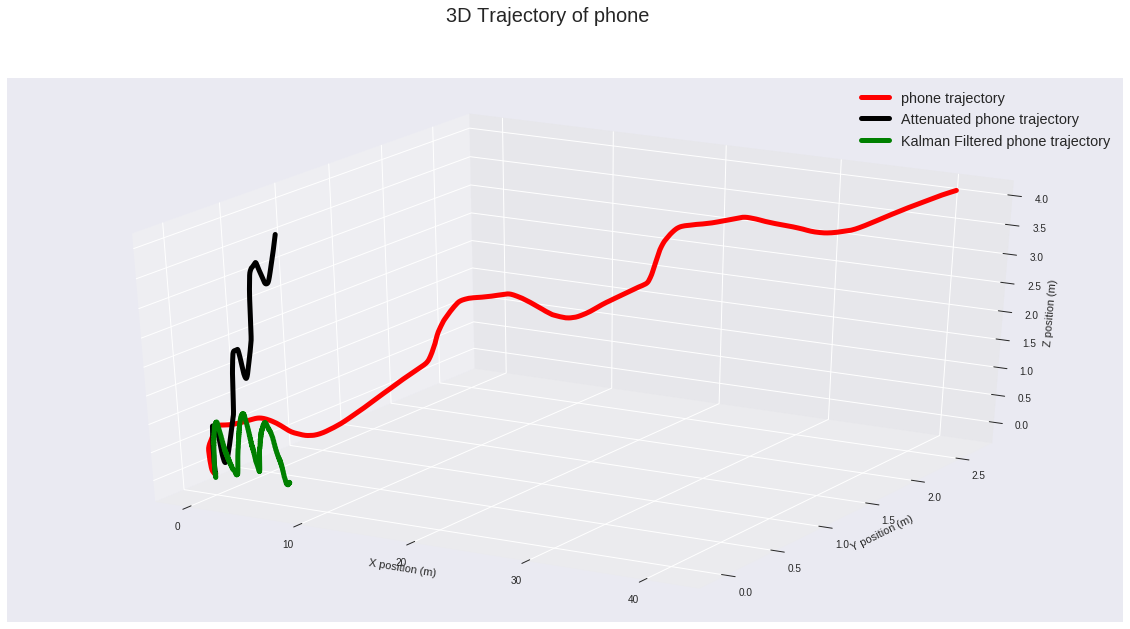

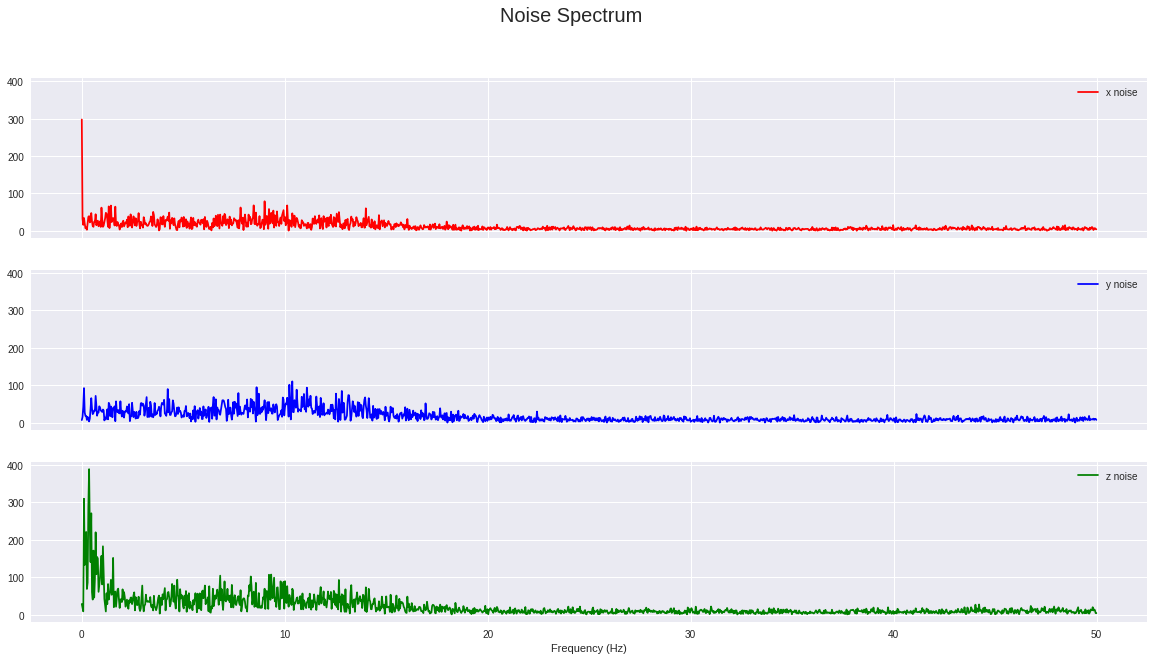

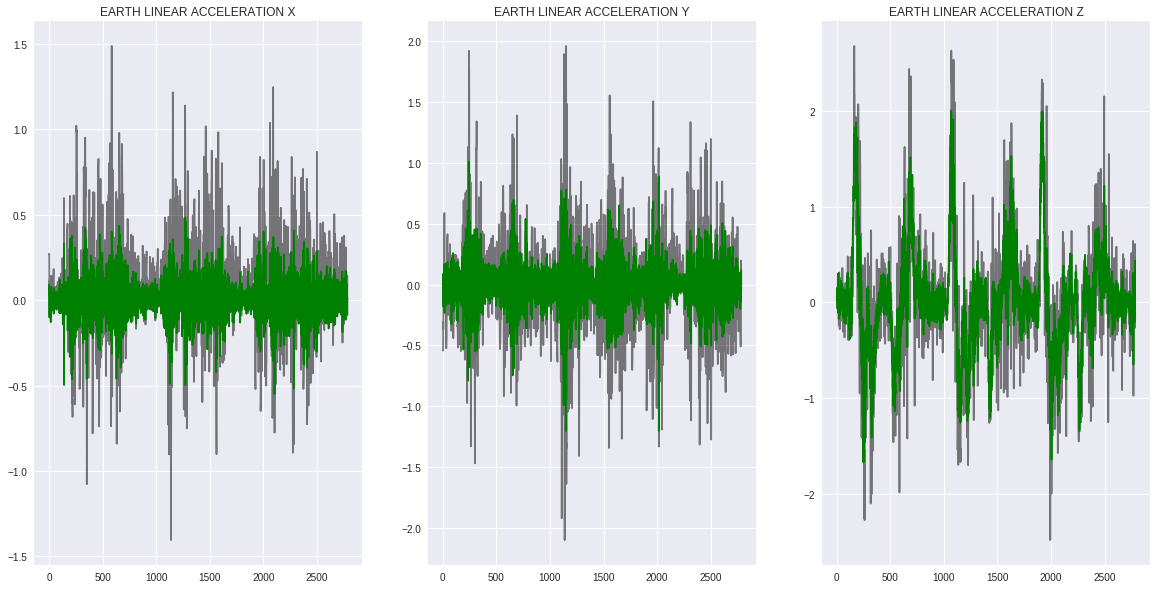

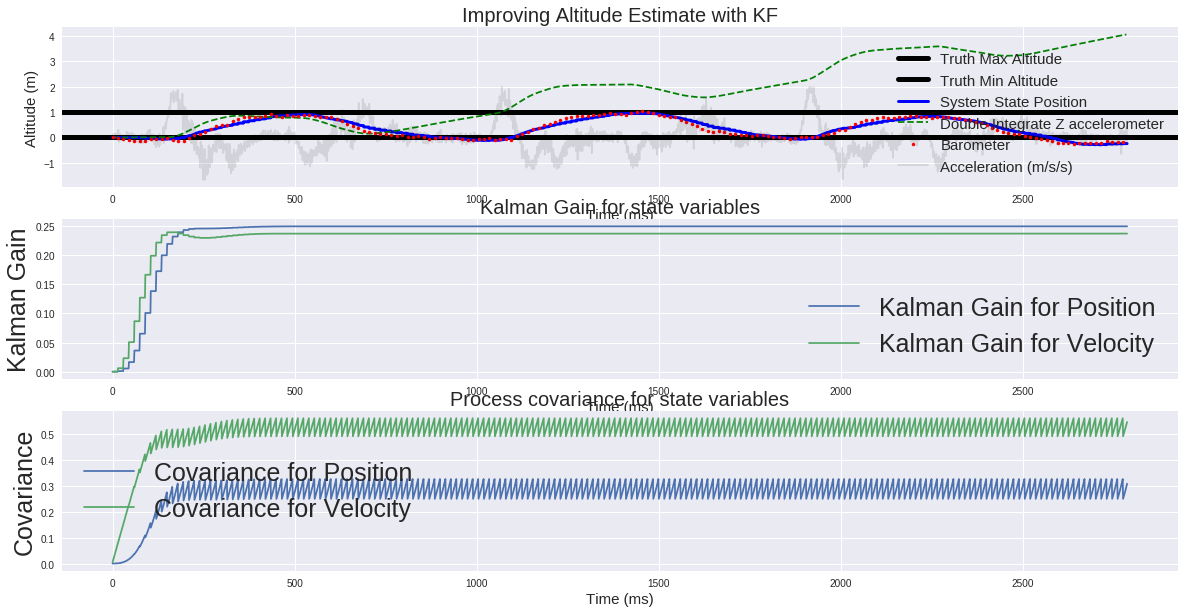

In [5]:

# Perform frame transformations (body frame --> earth frame)
for i in range(df.shape[0]):
    # accel_earth = (RzRyRx)(accel_body)
    earth_accels[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ accel[:,i]
    earth_gravity[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ grav[:,i]
    earth_linear[:,i] = R_z(yaw[i]) @ R_y(roll[i]) @ R_x(pitch[i]) @ line[:,i]

# Create new columns in dataframe for earth frame accelerations
df['EARTH ACCELERATION X'] = earth_accels[0,:]
df['EARTH ACCELERATION Y'] = earth_accels[1,:]
df['EARTH ACCELERATION Z'] = earth_accels[2,:]
df['EARTH GRAVITY X'] = earth_gravity[0,:]
df['EARTH GRAVITY Y'] = earth_gravity[1,:]
df['EARTH GRAVITY Z'] = earth_gravity[2,:]
df['EARTH LINEAR ACCELERATION X'] = earth_linear[0,:]
df['EARTH LINEAR ACCELERATION Y'] = earth_linear[1,:]
df['EARTH LINEAR ACCELERATION Z'] = earth_linear[2,:]

# Plot new accelerations
cols_earth = ['EARTH ACCELERATION X','EARTH ACCELERATION Y',
              'EARTH ACCELERATION Z','EARTH GRAVITY X','EARTH GRAVITY Y',
              'EARTH GRAVITY Z','EARTH LINEAR ACCELERATION X',
              'EARTH LINEAR ACCELERATION Y','EARTH LINEAR ACCELERATION Z']
cols_body = ['ACCELEROMETER X (m/s²)','ACCELEROMETER Y (m/s²)',
             'ACCELEROMETER Z (m/s²)', 'GRAVITY X (m/s²)', 'GRAVITY Y (m/s²)',
             'GRAVITY Z (m/s²)', 'LINEAR ACCELERATION X (m/s²)',
             'LINEAR ACCELERATION Y (m/s²)', 'LINEAR ACCELERATION Z (m/s²)',]

bodyplot = df.plot(y=cols_body,subplots=True,sharex=True,layout=(3,3),
                   title=cols_body,style='k',alpha=0.5)

df.plot(y=cols_earth,subplots=True,layout=(3,3),ax=bodyplot,sharex=True,
        style='g',title='Body Frame to Earth Frame Accelerations')

# Double integrate accelerations to find positions
x = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION X'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Y'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(df['EARTH LINEAR ACCELERATION Z'],dx=dt),dx=dt)

# Plot 3D Trajectory
fig3,ax = plt.subplots()
fig3.suptitle('3D Trajectory of phone',fontsize=20)
ax = plt.axes(projection='3d')
ax.plot3D(x,y,z,c='red',lw=5,label='phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize=20)

# # Notice drift in position

# Try to remove noise via Fourier analysis
    # Discrete Fourier Transform sample frequencies
freq = np.fft.rfftfreq(df['EARTH LINEAR ACCELERATION X'].size,d=dt)
# Compute the Fast Fourier Transform (FFT) of acceleration signals
fft_x = np.fft.rfft(df['EARTH LINEAR ACCELERATION X'])
fft_y = np.fft.rfft(df['EARTH LINEAR ACCELERATION Y'])
fft_z = np.fft.rfft(df['EARTH LINEAR ACCELERATION Z'])

# Plot Frequency spectrum
fig4,[ax1,ax2,ax3] = plt.subplots(3,1,sharex=True,sharey=True)
fig4.suptitle('Noise Spectrum',fontsize=20)
ax1.plot(freq,abs(fft_x),c='r',label='x noise')
ax1.legend()
ax2.plot(freq,abs(fft_y),c='b',label='y noise')
ax2.legend()
ax3.plot(freq,abs(fft_z),c='g',label='z noise')
ax3.legend()
ax3.set_xlabel('Frequency (Hz)')

# Attenuate noise in X,Y below 1Hz by 0.2
atten_x_fft = np.where(freq < 15,fft_x * 0.1, fft_x)
atten_y_fft = np.where(freq < 15,fft_y * 0.1, fft_y)
atten_z_fft = np.where((freq > 2) & (freq < 15),fft_z * 0.1, fft_z)
# Compute inverse of discrete Fourier Transform and save to dataframe
df['x_ifft'] = np.fft.irfft(atten_x_fft,n=df.shape[0])
df['y_ifft'] = np.fft.irfft(atten_y_fft,n=df.shape[0])
df['z_ifft'] = np.fft.irfft(atten_z_fft,n=df.shape[0])
# Plot new acceleration signals
cols_raw = ['EARTH LINEAR ACCELERATION X','EARTH LINEAR ACCELERATION Y',
            'EARTH LINEAR ACCELERATION Z']
cols_new = ['x_ifft','y_ifft','z_ifft']

rawplot = df.plot(y=cols_raw,subplots=True,sharex=True,layout=(1,3),style='k',
                    title=cols_raw,alpha=0.5,legend=False)

df.plot(y=cols_new,subplots=True,layout=(1,3),ax=rawplot,sharex=True,style='g',legend=False)

# Double integrate accelerations to calculate coordinate positions
x = cumtrapz(cumtrapz(df['x_ifft'],dx=dt),dx=dt)
y = cumtrapz(cumtrapz(df['y_ifft'],dx=dt),dx=dt)
z = cumtrapz(cumtrapz(df['z_ifft'],dx=dt),dx=dt)
# Plot attenuated 3D Trajectory
ax.plot3D(x,y,z,'k',lw=5,label='Attenuated phone trajectory')
ax.set_xlabel('X position (m)')
ax.set_ylabel('Y position (m)')
ax.set_zlabel('Z position (m)')
ax.legend(fontsize='x-large')

# =============================================================================
# # Kalman Filter Z position with barometer
# =============================================================================

# State Transition Matrix
A = np.array([[1.0, dt],
              [0.0, 1.0]])

# Control Matrix
B = np.array([[0.5*dt**2],
              [dt]])

# Control vector
u = np.array([[0.0]])

# Process Noise Matrix
max_position_change = 0.5 * 0.5 * dt**2  # assume max accel = 0.5
max_velocity_change = 0.5 * dt          # assume max accel = 0.5
Q = np.array([[max_position_change, 0],
              [0, max_velocity_change]])

# Measurement Matrix
H = np.array([[1, 0]])  # Only able to measure position

# Measurement noise covariance matrix
sbarometer = 1.0  # accurate to +- 1m
R = np.array([[sbarometer**2]])

# Measurement
z_m = np.array([[0.0]])

# Initial System State Matrix (pos_z = 0, vel_z = 0 at t = 0)
X = np.array([[0.0],
              [0.0]])

# Initial Process Covariance Matrix
spos = 0.0  # No uncertainty in initial state
svel = 0.0
P = np.array([[spos**2, svel*spos],
              [spos*svel, svel**2]])
# 2x2 Identity Matrix
I = np.eye(2)

X_pos = []
X_vel = []
P_pos = []
P_vel = []
K_pos = []
K_vel = []

# --- 1d Kalman Filter ---
for i in range(df.shape[0]):

    # Pull in z acceleration control input
    u[0][0] = df['z_ifft'][i]

    # Predict the next state
    X = A @ X + B @ u
    P = A @ P @ A.T + Q

    # Altitude measurement every 15 accelerometer updates (dt=0.01s vs dt_barometer = 0.015s)
    if i % 15 == 0:

        # Pull in altitude measurement
        z_m[0][0] = df['LOCATION Altitude-atmospheric pressure ( m)'][i]

        # Update the next state
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + R)  # Kalman Gain
        X = X + K @ (z_m - H @ X)                     # Updated State
        P = (I - K @ H) @ P                           # Updated Covariance

    # --- Store system states variables, Kalman Gain, and covariances ---
    X_pos.append(X[0][0])
    X_vel.append(X[1][0])
    P_pos.append(P[0][0])
    P_vel.append(P[1][1])
    K_pos.append(K[0][0])
    K_vel.append(K[1][0])
# -------------------------

# =============================================================================
# # Kalman Filter Plot
# =============================================================================
fig, axs = plt.subplots(nrows=3)
# Estimating Altitude Plot
axs[0].set_title('Improving Altitude Estimate with KF',fontsize=20)
axs[0].axhline(y=1,c='k',lw=5,label ='Truth Max Altitude')
axs[0].axhline(y=0,c='k',lw=5,label ='Truth Min Altitude')
axs[0].plot(X_pos,'b-',lw=3,label = 'System State Position')
axs[0].plot(z,'g--',label = 'Double Integrate Z accelerometer')
axs[0].plot(df['LOCATION Altitude-atmospheric pressure ( m)'][::15],
            'r.',lw=5,
            label='Barometer')
axs[0].plot(df['z_ifft'],label='Acceleration (m/s/s)',
            c='k',alpha=0.1)
axs[0].set_ylabel('Altitude (m)',fontsize=15)
axs[0].set_xlabel('Time (ms)',fontsize=15)
axs[0].legend(fontsize=15)

# Kalman Gain and Covariances
axs[1].set_title('Kalman Gain for state variables',
                 fontsize = 20)
axs[1].set_xlabel('Time (ms)',fontsize=15)
axs[1].plot(K_pos,label='Kalman Gain for Position')
axs[1].plot(K_vel,label='Kalman Gain for Velocity')
axs[1].set_ylabel('Kalman Gain',fontsize=25)
axs[1].legend(fontsize=25,loc='best')

axs[2].set_title('Process covariance for state variables',fontsize = 20)
axs[2].plot(P_pos,label='Covariance for Position')
axs[2].plot(P_vel,label='Covariance for Velocity')
axs[2].set_ylabel('Covariance',fontsize=25)
axs[2].set_xlabel('Time (ms)',fontsize=15)
axs[2].legend(fontsize=25,loc='best')

# Plot new trajectory on 3D plot
ax.plot3D(x,y,X_pos[:-2],'g',lw=5,label='Kalman Filtered phone trajectory')
ax.legend(fontsize='x-large')

plt.show()